# Text-to-Image and Image-to-image search Using CLIP and Comparitive Analysis

# Install libraries

In [1]:
! pip install transformers torch datasets gdcm pydicom lancedb onnx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:010m:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:0031m24.1 MB/s eta 0:00:01


# Import libraries

In [2]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load Dataset

In [3]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "conceptual_captions",
    split="train",
)

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

In [4]:
image_data

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 3318333
})

We will select a sample of 100 images from this large number of images

In [5]:
# taking first 100 images
image_data_df = pd.DataFrame(image_data[:100])

In [6]:
image_data_df.shape

(100, 2)

In [7]:
image_data_df.head()

,image_url,caption
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .


In [8]:
def check_valid_URLs(image_URL):
    """
    Not all the URLs are valid. This function returns True if the URL is valid. False otherwise.
    """
    try:
        response = requests.get(image_URL)
        Image.open(BytesIO(response.content))
        return True
    except:
        return False


def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image


def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [9]:
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [10]:
# removing all the in_valid URLs
image_data_df = image_data_df[image_data_df["is_valid"] == True]
image_data_df.head()

,image_url,caption,is_valid
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True


In [11]:
image_data_df = image_data_df.drop(["is_valid"], axis=1)

In [12]:
# checking image
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

/home/prashant/.local/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


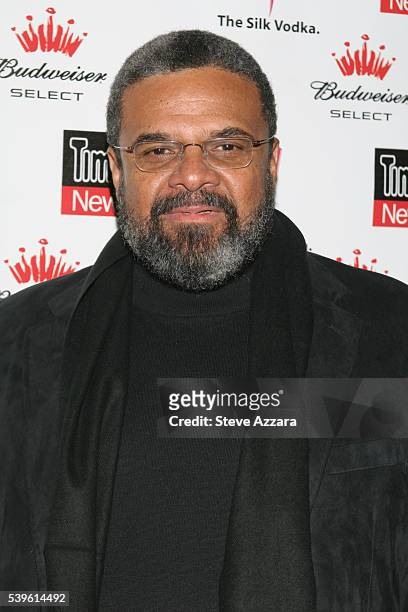

In [13]:
# show image
image_data_df.iloc[10]["image"]

# CLIP using Hugging Face

In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_model_info(model_ID, device):
    """
    Loading CLIP from HuggingFace
    """
    # Save the model to device
    model = CLIPModel.from_pretrained(model_ID).to(device)

    # Get the processor
    processor = CLIPProcessor.from_pretrained(model_ID)

    # Get the tokenizer
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)

    # Return model, processor & tokenizer
    return model, processor, tokenizer

In [61]:
# Set the device
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model_ID = "openai/clip-vit-base-patch16"

model, processor, tokenizer = get_model_info(model_ID, device)

# Create Embeddings using Hugging face model

### Helper functions to extract Text Embeddings

In [27]:
def get_single_text_embedding(text):
    # Get single text embeddings
    inputs = tokenizer(text, return_tensors="pt").to(device)

    text_embeddings = model.get_text_features(**inputs)

    # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()

    return embedding_as_np

In [28]:
def get_all_text_embeddings(df, text_col):
    # Get all the text embeddings
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

    return df

In [29]:
image_data_df.head()

,image_url,caption,image
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,<PIL.Image.Image image mode=RGB size=800x534 a...
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,<PIL.Image.Image image mode=RGB size=500x441 a...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,<PIL.Image.Image image mode=RGB size=490x612 a...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,<PIL.Image.Image image mode=RGB size=450x470 a...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,<PIL.Image.Image image mode=RGB size=450x470 a...


## Helper functions to extract Image Embeddings

In [30]:
def get_single_image_embedding(my_image):
    # Get single image embeddings
    image = processor(text=None, images=my_image, return_tensors="pt")[
        "pixel_values"
    ].to(device)

    embedding = model.get_image_features(image)

    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()

    return embedding_as_np

### Get the embedding of all the images

In [31]:
def get_all_images_embedding(df, img_column):
    # Get all image embeddings
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

    return df

### Helper function for showing images

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images):

    for image in images:
        plt.imshow(image)
        plt.show()


def plot_images_by_side(top_images):

    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    list_captions = [top_images.iloc[idx].caption for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

    n_row = n_col = 2

    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, caption, sim_score in zip(
        list_images, axs, list_captions, similarity_score
    ):
        ax.imshow(img)
        sim_score = 100 * float("{:.2f}".format(sim_score))
        ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
    plt.show()

### Connect LanceDB  

In [23]:
import lancedb

db = lancedb.connect("./.lancedb")

### Extracting Embeddings of 100 images from Hugging Face model

In [60]:
import time

# extracting embeddings using Hugging Face
start_time = time.time()
image_data_df = get_all_images_embedding(image_data_df, "image")
print(
    f"Time Taken to extract Embeddings of {len(image_data_df)} Images(in seconds): ",
    time.time() - start_time,
)

Time Taken to extract Embeddings of 83 Images(in seconds):  55.79400444030762


In [34]:
image_data_df.head()

,image_url,caption,image,img_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[-0.30967778, -1.0826486, 0.13600157, -0.3710..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[-0.0623585, -0.7061895, -0.32089347, 0.71978..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.4290247, 0.14772312, -0.24176186, 0.10169..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.07350698, 0.043649763, -0.34602094, 0.1352..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.4698937, 0.62030846, -0.49932033, -0.27193..."


## Database Insert

In [35]:
def create_and_ingest(image_data_df, table_name):
    """
    Create and Ingest Extracted Embeddings using Hugging Face
    """
    image_url = image_data_df.image_url.tolist()
    image_embeddings = [
        arr.astype(np.float32).tolist() for arr in image_data_df.img_embeddings.tolist()
    ]

    data = []
    for i in range(len(image_url)):
        temp = {}
        temp["vector"] = image_embeddings[i][0]
        temp["image"] = image_url[i]

        data.append(temp)

    # Create a Table
    tbl = db.create_table(name=table_name, data=data, mode="overwrite")
    return tbl

In [36]:
# create and ingest embeddings for pt model
pt_tbl = create_and_ingest(image_data_df, "pt_table")

[2023-12-09T16:50:42Z WARN  lance::dataset] No existing dataset at /home/prashant/Downloads/clip/.lancedb/pt_table.lance, it will be created


# Start the query

### Text to image

In [37]:
# quering using text
text_query = "actor arrives for the premiere of the film"

In [38]:
# Get the caption embedding and query for each caption

pt_text_results = {}
start_time = time.time()
for i in range(len(image_data_df)):
    text_query = image_data_df.iloc[i].caption
    query_embedding = get_single_text_embedding(text_query).tolist()

    # querying with query text
    result = pt_tbl.search(query_embedding[0]).limit(4).to_list()
    pt_text_results[str(i)] = result

### Image to image

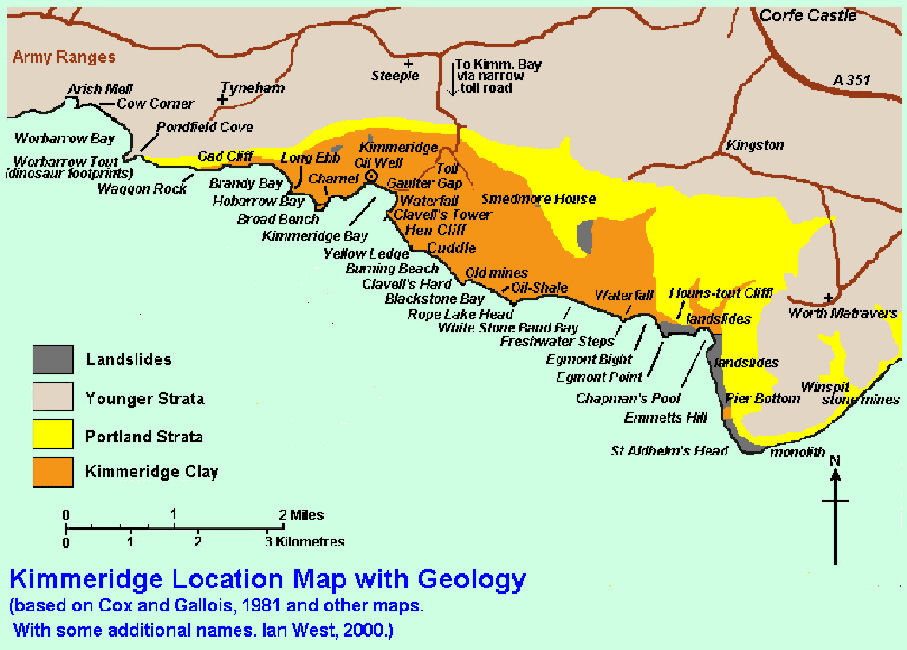

In [39]:
get_image(result[3]["image"])

In [41]:
# Get the image embedding and query for each caption
pt_img_results = {}

start_time = time.time()
for i in range(len(image_data_df)):
    img_query = image_data_df.iloc[i].image
    query_embedding = get_single_image_embedding(img_query).tolist()

    # querying with image
    result = pt_tbl.search(query_embedding[0]).limit(4).to_list()
    pt_img_results[str(i)] = result

print(
    f"Time taken to Extract Img embeddings and searching for {len(image_data_df)} images is ",
    time.time() - start_time,
)

Time taken to Extract Img embeddings and searching for 83 images is  55.26035737991333


# CLIP using OpenVINO

In [42]:
! pip install -q --extra-index-url https://download.pytorch.org/whl/cpu gradio "openvino>=2023.2.0" "transformers[torch]>=4.30"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.0.70 requires langchain<0.0.280,>=0.0.279, but you have langchain 0.0.335 which is incompatible.
embedchain 0.0.70 requires openai<0.28.0,>=0.27.5, but you have openai 0.28.1 which is incompatible.
embedchain 0.0.70 requires tiktoken<0.5.0,>=0.4.0, but you have tiktoken 0.5.1 which is incompatible.
poetry 1.1.12 requires packaging<21.0,>=20.4, but you have packaging 23.2 which is incompatible.


In [43]:
# inputs preparation for conversion and creating processor
text = image_data_df.iloc[10].caption
image = image_data_df.iloc[10].image
inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True)

In [44]:
import openvino as ov

# saving openvino model
model.config.torchscript = True
ov_model = ov.convert_model(model, example_input=dict(inputs))
ov.save_model(ov_model, "clip-vit-base-patch16.xml")

/home/prashant/.local/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/prashant/.local/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:327: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/prashant/.local/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:295: TracerWarning: Converting a ten

In [73]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

"""
  Compiling CLIP in Openvino FP16 format
"""

# create OpenVINO core object instance
core = Core()
# compile model for loading on device
compiled_model = core.compile_model(
    ov_model, device_name="CPU", config={"PERFORMANCE_HINT": "THROUGHPUT"}
)
# obtain output tensor for getting predictions

In [74]:
image_embeds = compiled_model.output(0)
logits_per_image_out = compiled_model.output(0)

image_url = image_data_df.image_url.tolist()
image_embeddings = []


def extract_openvino_embeddings(image_data_df):
    """
    Extracting Image Embeddings using Openvino
    """
    for i in range(len(image_data_df)):
        image = image_data_df.iloc[i].image
        inputs = processor(images=[image], return_tensors="np", padding=True)
        image_embeddings.append(compiled_model(dict(inputs))["image_embeds"][0])

    return image_embeddings

In [75]:
import time

# time taken to extract embeddings using CLIP Openvino format
start_time = time.time()
image_embeddings = extract_openvino_embeddings(image_data_df)
print(
    f"Time Taken to extract Embeddings of {len(image_data_df)} Images(in seconds): ",
    time.time() - start_time,
)

Time Taken to extract Embeddings of 83 Images(in seconds):  31.79015016555786


## Database Insert

In [51]:
def create_and_ingest_openvino(image_url, image_embeddings, table_name):
    """
    Create and Ingest Extracted Embeddings using Openvino FP16 format
    """
    data = []
    for i in range(len(image_url)):
        temp = {}
        temp["vector"] = image_embeddings[i]
        temp["image"] = image_url[i]

        data.append(temp)

    # Create a Table
    tbl = db.create_table(name=table_name, data=data, mode="overwrite")
    return tbl

In [52]:
# create and ingest embeddings for openvino fp16 model
ov_tbl = create_and_ingest_openvino(image_url, image_embeddings, "ov_tbl")

[2023-12-09T17:01:26Z WARN  lance::dataset] No existing dataset at /home/prashant/Downloads/clip/.lancedb/ov_tbl.lance, it will be created


In [53]:
# Get the image embedding and query for each caption
ov_img_results = {}
start_time = time.time()
for i in range(len(image_data_df)):
    img_query = image_data_df.iloc[i].image
    image = image_data_df.iloc[i].image
    inputs = processor(images=[image], return_tensors="np", padding=True)
    query_embedding = compiled_model(dict(inputs))["image_embeds"][0]

    # querying with query image
    result = ov_tbl.search(query_embedding).limit(4).to_list()
    ov_img_results[str(i)] = result

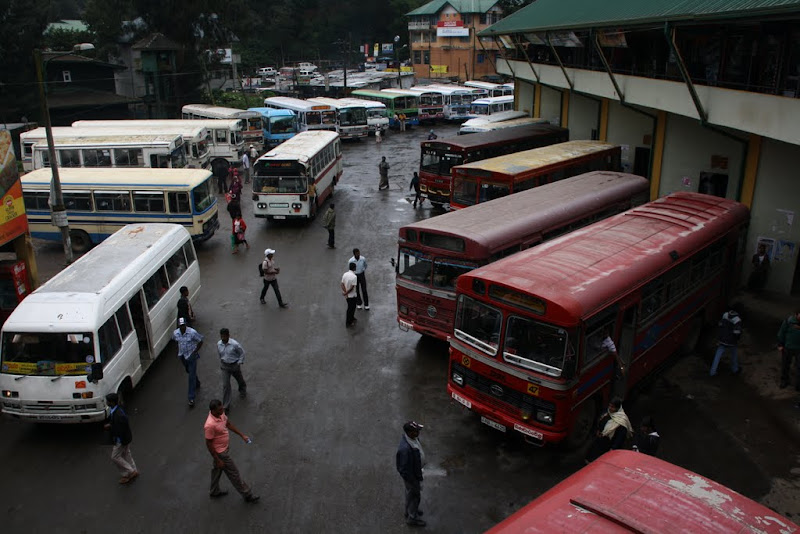

In [54]:
get_image(ov_img_results["0"][0]["image"])

# Post Training Optimization (NNCF Quantization) using OpenVINO
### Converting CLIP into INT8 format in OpenVINO

In [55]:
%pip install -q datasets
%pip install -q "nncf>=2.7.0"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nemo-toolkit 1.20.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.1 which is incompatible.
nemo-toolkit 1.20.0 requires setuptools==65.5.1, but you have setuptools 68.2.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import os

fp16_model_path = "clip-vit-base-patch16.xml"

In [65]:
from transformers import CLIPProcessor, CLIPModel

# inputs preparation for conversion and creating processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
max_length = model.config.text_config.max_position_embeddings
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [66]:
import requests
from io import BytesIO
import numpy as np
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False


def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")


def collate_fn(example, image_column="image_url", text_column="caption"):
    """
    Preprocesses an example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        h, w = image.size
        if h == 1 or w == 1:
            return None
    except Exception:
        return None

    # preparing inputs for processor
    inputs = processor(
        text=example[text_column], images=[image], return_tensors="pt", padding=True
    )
    if inputs["input_ids"].shape[1] > max_length:
        return None
    return inputs

In [67]:
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm


def prepare_calibration_data(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} for the initialization...")
    counter = 0
    for batch in tqdm(dataloader):
        if counter == init_steps:
            break
        if batch:
            counter += 1
            with torch.no_grad():
                data.append(
                    {
                        "pixel_values": batch["pixel_values"].to("cpu"),
                        "input_ids": batch["input_ids"].to("cpu"),
                        "attention_mask": batch["attention_mask"].to("cpu"),
                    }
                )
    return data


def prepare_dataset(opt_init_steps=300, max_train_samples=1000):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("conceptual_captions", streaming=True)
    train_dataset = dataset["train"].shuffle(seed=42, buffer_size=max_train_samples)
    dataloader = torch.utils.data.DataLoader(
        train_dataset, collate_fn=collate_fn, batch_size=1
    )
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

In [68]:
import logging
import nncf
from openvino.runtime import Core, serialize

core = Core()

# Initialize NNCF
nncf.set_log_level(logging.ERROR)

int8_model_path = "clip-vit-base-patch16_int8.xml"
calibration_data = prepare_dataset()
ov_model = core.read_model(fp16_model_path)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino
Fetching 300 for the initialization...


0it [00:00, ?it/s]

In [69]:
if len(calibration_data) == 0:
    raise RuntimeError(
        "Calibration dataset is empty. Please check internet connection and try to download images manually."
    )

# Quantize CLIP fp16 model using NNCF
calibration_dataset = nncf.Dataset(calibration_data)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
)

# Saving Quantized model
serialize(quantized_model, int8_model_path)

Output()

Output()

Output()

Output()

Output()

Output()

### Run Quantized Model

In [71]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

# create OpenVINO core object instance
core = Core()
# compile model for loading on device
compiled_model = core.compile_model(
    quantized_model, device_name="CPU", config={"PERFORMANCE_HINT": "THROUGHPUT"}
)

# obtain output tensor for getting predictions
image_embeds = compiled_model.output(0)
logits_per_image_out = compiled_model.output(0)

image_url = image_data_df.image_url.tolist()
image_embeddings = []


def extract_quantized_openvino_embeddings(image_data_df, compiled_model):
    """
    Extract embeddings of Images using CLIP Quantized model
    """
    for i in range(len(image_data_df)):
        image = image_data_df.iloc[i].image
        inputs = processor(images=[image], return_tensors="np", padding=True)
        image_embeddings.append(compiled_model(dict(inputs))["image_embeds"][0])

    return image_embeddings

In [72]:
import time

start_time = time.time()

# time taken to extract embeddings using CLIP Openvino format
image_embeddings = extract_quantized_openvino_embeddings(image_data_df, compiled_model)

print(
    f"Time Taken to extract Embeddings of {len(image_data_df)} Images(in seconds): ",
    time.time() - start_time,
)

Time Taken to extract Embeddings of 83 Images(in seconds):  13.70863938331604


In [76]:
# create and ingest embeddings for openvino int8 model format
qov_tbl = create_and_ingest_openvino(image_url, image_embeddings, "qov_tbl")

[2023-12-09T17:38:30Z WARN  lance::dataset] No existing dataset at /home/prashant/Downloads/clip/.lancedb/qov_tbl.lance, it will be created


In [78]:
# Get the image embedding and query for each caption
ov_img_results = {}
start_time = time.time()
for i in range(len(image_data_df)):
    img_query = image_data_df.iloc[i].image
    image = image_data_df.iloc[i].image
    inputs = processor(images=[image], return_tensors="np", padding=True)
    query_embedding = compiled_model(dict(inputs))["image_embeds"][0]

    # querying with query image
    result = qov_tbl.search(query_embedding).limit(4).to_list()
    ov_img_results[str(i)] = result

In [79]:
pt_latency = 55.26
fp16_latency = 31.79
int8_latency = 13.70
print(f"Performance speed up using FP16 format: {pt_latency / fp16_latency:.3f}")
print(f"Performance speed up using Int8 format: {pt_latency / int8_latency:.3f}")

Performance speed up using FP16 format: 1.738
Performance speed up using Int8 format: 4.034


In [80]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 186
model name	: 13th Gen Intel(R) Core(TM) i5-13420H
stepping	: 2
microcode	: 0x411c
cpu MHz		: 3575.295
cache size	: 12288 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 8
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 32
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap clflushopt clwb intel_pt sha_ni xsaveopt xsave

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [81]:
!cat /proc/meminfo

MemTotal:        7819972 kB
MemFree:          324644 kB
MemAvailable:     956452 kB
Buffers:           13388 kB
Cached:          1245868 kB
SwapCached:       499612 kB
Active:          2018208 kB
Inactive:        4327040 kB
Active(anon):    1611340 kB
Inactive(anon):  4040560 kB
Active(file):     406868 kB
Inactive(file):   286480 kB
Unevictable:       84564 kB
Mlocked:              48 kB
SwapTotal:      20824060 kB
SwapFree:       10418076 kB
Zswap:                 0 kB
Zswapped:              0 kB
Dirty:               388 kB
Writeback:            12 kB
AnonPages:       4989488 kB
Mapped:           631844 kB
Shmem:            565908 kB
KReclaimable:     251608 kB
Slab:             537912 kB
SReclaimable:     251608 kB
SUnreclaim:       286304 kB
KernelStack:       32112 kB
PageTables:       111640 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    24734044 kB
Committed_AS:   32765328 kB
VmallocTotal:   3435

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Conclusion

All these results are on CPU for comparison of Pytorch model with Openvino format model

**Time Taken to extract 100 Images Embeddings using CLIP using**<br>
1. Pytorch model from Hugging Face - 55.26 seconds
2. Openvino FP16 format - 31.79 seconds
3. Openvino Int8 format - 13.70 seconds
<br>

**Performance speed up using FP16 model is 1.73 times which is not much acceleration compared to speed.**

**But on the otherside when we see INT8 openvino format, it speeds up by 4.03 times compared to Pytorch model.**

